# Using nltk functionality to preprocess text data

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Reading data set

In [187]:
data = pd.read_csv('Dataset/SMSSpamCollection',header=None,delimiter='\t',encoding='utf-8')
data[0:5]

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Encode labels as 1 and 0

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data.iloc[:,0])
y

array([0, 0, 1, ..., 0, 0, 0])

### Visualizing balance of the dataset

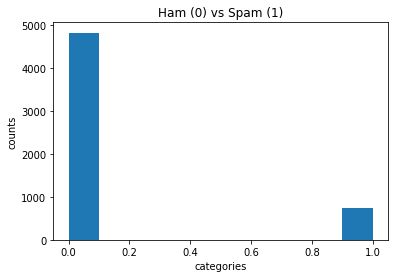

In [4]:
plt.hist(y)
plt.title('Ham (0) vs Spam (1)')
plt.ylabel('counts')
plt.xlabel('categories')
plt.show()

In [179]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler
def preprocess(text):
    # take a text string and break them down into ready-to-use word tokens
    def sub_text(text):
        # Replaces information such as email and websites within a string
        # Replace emails addresses
        sub_text = re.sub(r'[a-z0-9_]+@[a-z0-9]+(\.[a-z0-9]+)+','emailaddress',text)
        # Replace website
        sub_text = re.sub(r'https\://[a-z0-9\._%/]+','webaddress',sub_text)
        # Replace number
        sub_text = re.sub(r'\d+(\.\d)?','numbr',sub_text)
        # Replace phone number
        sub_text = re.sub(r'\(?([0-9]{3}[- \)]?){2}[0-9]{4}','phonenumber',sub_text)
        # Replace money symbol
        sub_text = re.sub(r'\$|£','moneysymbol',sub_text)
        # Replace punctuations with spaces
        sub_text = re.sub(r'[\(\)\.\?\:,!]',' ',sub_text)
        return sub_text
    # Call sub_text function
    text = sub_text(text)
    # Put everything into lower case
    text = text.lower()
    # Tokenize into words for each string
    word_toks = word_tokenize(text)
    # Remove stopwords
    stop_words = stopwords.words('english')
    word_toks = [w for w in word_toks if w not in stop_words]
    # Perform stemming
    ps = PorterStemmer()
    word_toks = [ps.stem(w) for w in word_toks]
    return word_toks
# proprocess into list of list of word tokens
samples = [preprocess(text) for text in texts]

# Make bag-of-words feature with 1500 most common words
all_words = []
for word_toks in samples:
    all_words += word_toks
freq_words = FreqDist(all_words)
common_words = list(freq_words.keys())[0:1500]

def generate_features(sample):
    # search for all 1500 of most common words in the token list of each sample
    sample = set(sample)
    feature = np.array([w in sample for w in common_words]).astype(int)
    return feature
X = np.array([generate_features(sample) for sample in samples])
# Feature Scaling
standard = StandardScaler()
X_scaled = standard.fit_transform(X.astype(float))

## Training models

### Use cross validation methods to more accurately determine the metrics

In [148]:
# kfold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5,random_state=1)
# Standardize data
from sklearn.preprocessing import StandardScaler

### Try several different models and evaluate each of each performances. Using f1 score to better evaluate an imbalanced dataset.

In [157]:
# import all algorithms to try out
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

svm_linear = SVC(kernel='linear',class_weight='balanced')
svm_rbf = SVC(kernel='rbf',class_weight='balanced')
adaboost = AdaBoostClassifier()
Random_Forest = RandomForestClassifier()
KNN = KNeighborsClassifier()
names = ['svm_linear','svm_rbf','adaboost','Random_Forest','KNN']
models = [svm_linear,svm_rbf,adaboost,Random_Forest,KNN]
scores = []
for model in models:
    scores.append(np.average(cross_val_score(model,X_scaled,y,cv=kfold,scoring='f1')))

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

### Evaluation: Random Forest has the best performance

In [158]:
for name,score in zip(names,scores):
    print('name:{},scores:{}'.format(name,score))

name:svm_linear,scores:0.8720464758778489
name:svm_rbf,scores:0.8791512786830946
name:adaboost,scores:0.9042098238550935
name:Random_Forest,scores:0.9238585657909837
name:KNN,scores:0.6087643276942559


In [164]:
from sklearn.metrics import classification_report
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y)
Random_Forest.fit(X_train,y_train)
print(classification_report(y_test,Random_Forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.99      0.87      0.93       187

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.98      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [179]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler
def preprocess(text):
    # take a text string and break them down into ready-to-use word tokens
    def sub_text(text):
        # Replaces information such as email and websites within a string
        # Replace emails addresses
        sub_text = re.sub(r'[a-z0-9_]+@[a-z0-9]+(\.[a-z0-9]+)+','emailaddress',text)
        # Replace website
        sub_text = re.sub(r'https\://[a-z0-9\._%/]+','webaddress',sub_text)
        # Replace number
        sub_text = re.sub(r'\d+(\.\d)?','numbr',sub_text)
        # Replace phone number
        sub_text = re.sub(r'\(?([0-9]{3}[- \)]?){2}[0-9]{4}','phonenumber',sub_text)
        # Replace money symbol
        sub_text = re.sub(r'\$|£','moneysymbol',sub_text)
        # Replace punctuations with spaces
        sub_text = re.sub(r'[\(\)\.\?\:,!]',' ',sub_text)
        return sub_text
    # Call sub_text function
    text = sub_text(text)
    # Put everything into lower case
    text = text.lower()
    # Tokenize into words for each string
    word_toks = word_tokenize(text)
    # Remove stopwords
    stop_words = stopwords.words('english')
    word_toks = [w for w in word_toks if w not in stop_words]
    # Perform stemming
    ps = PorterStemmer()
    word_toks = [ps.stem(w) for w in word_toks]
    return word_toks
# proprocess into list of list of word tokens
samples = [preprocess(text) for text in texts]

# Make bag-of-words feature with 1500 most common words
all_words = []
for word_toks in samples:
    all_words += word_toks
freq_words = FreqDist(all_words)
common_words = list(freq_words.keys())[0:1500]

def generate_features(sample):
    # search for all 1500 of most common words in the token list of each sample
    sample = set(sample)
    feature = np.array([w in sample for w in common_words]).astype(int)
    return feature
X = np.array([generate_features(sample) for sample in samples])
# Feature Scaling
standard = StandardScaler()
X_scaled = standard.fit_transform(X.astype(float))

In [175]:
scam1 = 'User #25384: Your Gmail profile has been compromised. Text back SENDNOW in order to reactivate your account.'

tokens = preprocess(scam1)
X1 = np.array([generate_features(tokens)])
X1_scaled = standard.transform(X1.astype(float))
Random_Forest.predict(X1_scaled)

array([1])

In [176]:
ham1 = 'Yeah, it took an extra hour though. Our train totally malfunctioned'
tokens = preprocess(ham1)
X1 = np.array([generate_features(tokens)])
X1_scaled = standard.transform(X1.astype(float))
Random_Forest.predict(X1_scaled)

array([0])

In [ ]:
from sklearn.metrics import 

In [ ]:
a = [1,2,3]


In [ ]:
a = ['1','2','3']


### Data preprocessing using Regex
1) 

In [180]:
import re
a = 'this is my email address: chrislyc_1991@gmail.com.net. Please email me back.'
re.sub(r'[a-z0-9_]+@[a-z0-9]+(\.[a-z0-9]+)+','emailaddress',a)

'this is my email address: emailaddress. Please email me back.'

In [182]:
b = 'go to this website (https://docs.python.org/2/library/re.html) to check out a python tutorial'
re.sub(r'https\://[a-z0-9\._%/]+','webaddress',b)

'go to this website (webaddress) to check out a python tutorial'

In [184]:
c1 = 'You can reach me by 8018192346'
c2 = 'You can reach me by 801-819-2346'
c3 = 'You can reach me by (801)8192346'
c4 = 'You can reach me by 801 819 2346'
print(re.sub(r"\(?([0-9]{3}[- \)]?){2}[0-9]{4}",'phonenumbr',c1))
print(re.sub(r"\(?([0-9]{3}[- \)]?){2}[0-9]{4}",'phonenumbr',c2))
print(re.sub(r"\(?([0-9]{3}[- \)]?){2}[0-9]{4}",'phonenumbr',c3))
print(re.sub(r"\(?([0-9]{3}[- \)]?){2}[0-9]{4}",'phonenumbr',c4))

You can reach me by phonenumbr
You can reach me by phonenumbr
You can reach me by phonenumbr
You can reach me by phonenumbr


In [185]:
number = '$300.0'
re.sub(r'\d+(\.\d)?','numbr',number)

'$numbr'

In [186]:
re.sub(r'\$|£','moneysym',number)

'moneysym300.0'

### References